In [1]:
using Plots, LinearAlgebra

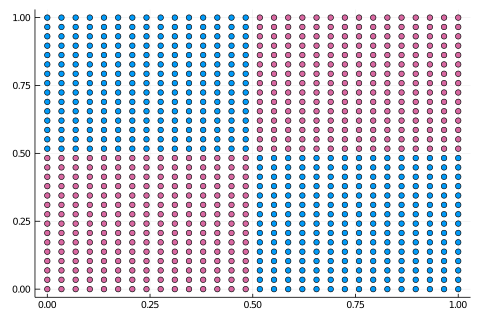

In [2]:
domain = range(0, stop=1, length=30)
dataset = vec([([x1, x2], round(Int64, x1) ⊻ round(Int64, x2)) for x1 in domain, x2 in domain])
scatter(map(x->x[1][1], dataset), map(x->x[1][2], dataset), color=map(x -> x[2][1], dataset), dpi=20, legend=false)

---

# "Almost" Zero-Allocation Neural Network

- https://stackoverflow.com/questions/38235555/tensorflow-matmul-of-input-matrix-with-batch-data
- https://www.google.com/search?q=batch+matrix+multiplication%5C&oq=batch+matrix+multiplication%5C&aqs=chrome..69i57j0i457j0l5j69i60.2539j0j7&sourceid=chrome&ie=UTF-8
- https://discourse.julialang.org/t/multiply-many-matrices-by-many-vectors/18542
- https://stackoverflow.com/questions/43801699/julia-multiply-each-matrix-along-dim

Network creation
  0.000049 seconds (22 allocations: 7.781 KiB)
Prediction


  0.136463 seconds (297.61 k allocations: 14.622 MiB)
Backpropagation
  0.000211 seconds (308 allocations: 432.734 KiB)


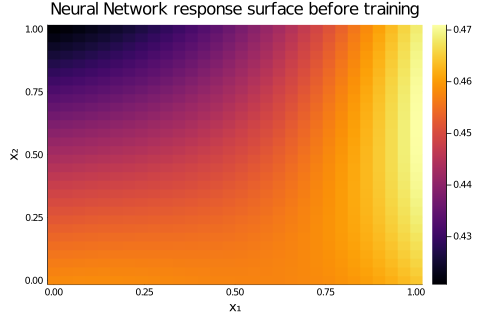

In [8]:
module ZeroAllocationNN

export ZANN
mutable struct ZANN
    weights :: Vector{Matrix{Float64}}
    biases :: Vector{Vector{Float64}}
    
    weighted_inputs :: Vector{Matrix{Float64}}
    activations :: Vector{Matrix{Float64}}
        
    nabla_ws :: Vector{Array{Float64,3}}
    nabla_bs :: Vector{Matrix{Float64}}
    
    function ZANN(layer_dims)
        weights = []
        biases = []
        for i = 2:length(layer_dims)
            push!(weights, randn(layer_dims[i], layer_dims[i - 1]))
            push!(biases, randn(layer_dims[i]))
        end
        return new(
            weights,
            biases,
            Vector{Vector{Float64}}(undef, length(layer_dims) - 1),
            Vector{Vector{Float64}}(undef, length(layer_dims)),
            Vector{Matrix{Float64}}(undef, length(layer_dims) - 1),
            Vector{Vector{Float64}}(undef, length(layer_dims) - 1)
        )
    end
end

sigma(x) = 1 / (1 + exp(-x))
sigma_prime(x) = sigma(x)*(1-sigma(x))

export predict
function predict(nn::ZANN, x :: Matrix{Float64})
    a = x
    for (w, b) in zip(nn.weights, nn.biases)
        a = sigma.(w * a .+ b) # .+ to repeat b along axis 1 (the minibatch size axis)
    end
    return a
end



export backprop
function backprop(nn::ZANN, x :: Matrix{Float64}, y :: Matrix{Float64})
    # forward pass, the difference from predict is that we save the activations
    # and the weighted inputs
    nn.activations[1] = x
    
    for (i, (w, b)) in enumerate(zip(nn.weights, nn.biases))
        nn.weighted_inputs[i] = w * nn.activations[i]
        @. nn.weighted_inputs[i] += b
        nn.activations[i+1] = sigma.(nn.weighted_inputs[i])
    end
    
    # backward pass
    # BP1 (Output layer error)
    delta :: Matrix{Float64} = (nn.activations[end] - y) .* sigma_prime.(nn.weighted_inputs[end])

    # BP3 (Cost gradient w.r.t Bias)
    nn.nabla_bs[1] = delta
    
    # BP4 (Cost gradient w.r.t weights)
    # TODO(Andrea): cleanup
    size(delta, 2) == size(nn.activations[end-1], 2) || throw(DimensionMismatch("size(A, 2) must equal size(B, 2), found $(size(delta, 2)) and $(size(nn.activations[end-1], 2)) instead"))
    nn.nabla_ws[1] = Array{Float64, 3}(undef, size(delta, 1), size(nn.activations[end-1], 1), size(delta, 2))
    for i in 1:size(delta, 2)
        nn.nabla_ws[1][:,:,i] = delta[:,i] * nn.activations[end-1][:,i]'
    end
    
    for (i,(w, z, a)) in enumerate(Iterators.reverse(zip(
                    nn.weights, nn.weighted_inputs[1:end-1], nn.activations[1:end-2])))
        # BP2 (Previous layer error)
        delta = (w'*delta)
        @. delta *= sigma_prime(z)
        
        nn.nabla_bs[i+1] = delta
        
        # TODO(Andrea): cleanup
        size(delta, 2) == size(a, 2) || throw(DimensionMismatch("size(A, 2) must equal size(B, 2), found $(size(delta, 2)) and $(size(a, 2)) instead"))
        nn.nabla_ws[i+1] = Array{Float64, 3}(undef, size(delta, 1), size(a, 1), size(delta, 2))
        for j in 1:size(delta, 2)
            nn.nabla_ws[i+1][:,:,j] = delta[:,j] * a[:,j]'
        end
    end
    
    return reverse(nn.nabla_ws), reverse(nn.nabla_bs)
end
end

import Main.ZeroAllocationNN

println("Network creation")
@time zann = ZeroAllocationNN.ZANN([2,30,20,1]);

println("Prediction")
@time ZeroAllocationNN.predict(zann,collect(vcat(map(r->r[1], rand(dataset, 32))'...)'))

println("Backpropagation")
@time ZeroAllocationNN.backprop(zann, randn(2, 32), randn(1, 32));

heatmap(
    domain,
    domain,
    (x1, x2) -> ZeroAllocationNN.predict(zann, reshape([x1; x2], 2, :))[1],
    title="Neural Network response surface before training",
    xlabel="x₁",
    ylabel="x₂",
    dpi=20
)

---
## STOCHASTIC GRADIENT DESCENT (minibatch_size = 16)

 11.310198 seconds (19.66 M allocations: 13.857 GiB, 9.41% gc time)


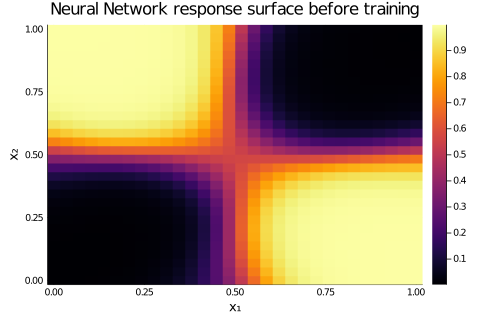

In [7]:
epochs = 60_000
minibatch_size = 15
eta = 0.05
@time for epoch in 1:epochs
    minibatch = rand(dataset, minibatch_size)
    x = hcat(map(x->x[1], minibatch)...)
    y = hcat(map(x->float(x[2]), minibatch)...)
    delta_nabla_ws, delta_nabla_bs = ZeroAllocationNN.backprop(zann, x, y)

    nabla_ws = map(x->x[:,:,1], sum.(delta_nabla_ws, dims=3)) / minibatch_size
    nabla_bs = map(x->x[:,1], sum.(delta_nabla_bs, dims=2)) / minibatch_size
    
    zann.weights -= (eta * nabla_ws)
    zann.biases -= (eta * nabla_bs)
end

heatmap(
    domain,
    domain,
    (x1, x2) -> ZeroAllocationNN.predict(zann, reshape([x1; x2], 2, :))[1],
    title="Neural Network response surface before training",
    xlabel="x₁",
    ylabel="x₂",
    dpi=20
)

---
## ONLINE GRADIENT DESCENT (minibatch_size = 1)

In [5]:
# TODO(Andrea):  this should be more like:
#     14.545116 seconds (41.79 M allocations: 18.513 GiB, 16.75% gc time)

 43.962975 seconds (113.90 M allocations: 36.797 GiB, 7.38% gc time)


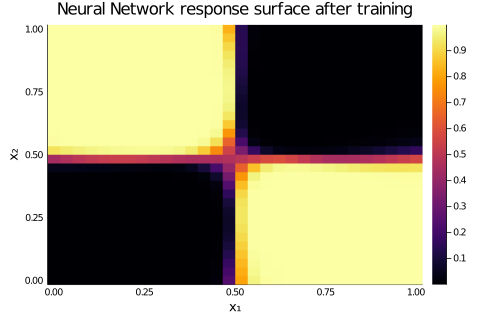

In [9]:
epochs = 1_000
eta = 0.05
@time for epoch in 1:epochs
    for (x, y) in dataset
        delta_nabla_ws, delta_nabla_bs = ZeroAllocationNN.backprop(zann, reshape(x, :, 1), reshape([float(y)], :, 1))

        nabla_ws = map(x->x[:,:,1], sum.(delta_nabla_ws, dims=3))
        nabla_bs = map(x->x[:,1], sum.(delta_nabla_bs, dims=2))

        zann.weights -= eta * nabla_ws
        zann.biases -= eta * nabla_bs
    end
end
heatmap(
    domain,
    domain,
    (x1, x2) -> ZeroAllocationNN.predict(zann, reshape([x1; x2], 2, :))[1],
    title="Neural Network response surface after training",
    xlabel="x₁",
    ylabel="x₂",
    dpi=20
)